# 2D Heat Equation Solver

## 🌡️ Numerical Methods for Heat Diffusion

This notebook demonstrates the implementation and comparison of two numerical methods for solving the 2D heat diffusion equation:

1. **Explicit Euler Method** - Simple but stability-limited
2. **Crank-Nicolson Method** - Implicit and unconditionally stable

### Mathematical Background

We solve the 2D heat diffusion equation:

$$\frac{\partial u}{\partial t} = \alpha \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

Where:
- $u(x,y,t)$ is the temperature at point $(x,y)$ at time $t$
- $\alpha$ is the thermal diffusion coefficient

In [1]:
# Import necessary libraries
import numpy as np
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve

%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import mplcursors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Aktuelles Backend:", plt.get_backend())

Aktuelles Backend: module://matplotlib_inline.backend_inline


## 🔧 Parameters and Initial Setup

In [2]:
# Grid parameters
nx, ny = 30, 30        # Number of grid points
lx, ly = 1.0, 1.0      # Domain size
dx, dy = lx/nx, ly/ny  # Grid spacing

# Physical parameters
alpha = 0.01           # Diffusion coefficient
dt = 0.0005            # Time step
nt = 200               # Number of time steps
nts = [0, 50, 100, 150, 200] # Time steps for analysis

# Create coordinate grids for visualization
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

print(f"Grid resolution: {nx}×{ny}")
print(f"Domain size: {lx}×{ly}")
print(f"Grid spacing: dx={dx:.4f}, dy={dy:.4f}")
print(f"Time step: dt={dt}")
print(f"Diffusion coefficient: α={alpha}")

# initial value
center_value = 50.0

a=1; b=0; c=20.0  # Dirichlet boundary condition u=20 on the boundary
# a=0; b=1; c=1.0  # Neumann boundary condition u=20 on the boundary
a=1; b=1; c=20  # Robin boundary condition u=20 on the boundary

execute_animation = False
execute_animation = True

Grid resolution: 30×30
Domain size: 1.0×1.0
Grid spacing: dx=0.0333, dy=0.0333
Time step: dt=0.0005
Diffusion coefficient: α=0.01


## Boundary conditions
### Boundary Conditions for the explicit Euler scheme
Robin's boundary condition, i.e.
$a u + b \frac{\partial u}{\partial n} = c$
   * a = 0 : Neumann boundary condition 
   * b = 0 : Dirichlet boundary condition
   * c = 0 : Homogeneous boudary condition

In [3]:
# apply boundary conditions for explicit scheme
# a = 0 : Neumann boundary condition 
# b = 0 : Dirichlet boundary condition
# c = 0 : Homogeneous boundary condition
def apply_heat_boundary_condition(u, dx, dy, a, b, c):
    # left boundary
    u[0,1:-1] = (dx*c + b*u[1,1:-1])/(b + a*dx)
    # right boundary
    u[-1,1:-1] = (dx*c + b*u[-2,1:-1])/(b + a*dx)
    # lower boundary
    u[1:-1, 0] = (dy*c + b*u[1:-1, 1])/(b + a*dy)
    # upper boundary
    u[1:-1, -1] = (dy*c + b*u[1:-1, -2])/(b + a*dy)
    # lower left corner
    u[0,0] = 0.5*(u[1, 0] + u[0,1])
    # lower right corner
    u[-1,0] = 0.5*(u[-2, 0] + u[-1,1])
    # upper right corner
    u[-1,-1] = 0.5*(u[-2, -1] + u[-1, -2])
    # upper left corner
    u[0,-1] = 0.5*(u[1, -1] + u[0, -2])

## Verification of the boundary conditions

In [4]:
# apply boundary conditions for explicit scheme
# a = 0 : Neumann boundary condition 
# b = 0 : Dirichlet boundary condition
# c = 0 : Homogeneous boudary condition
def verify_boundary_condition(u, dx, dy, a, b, c):
    # left boundary
    res1 = a*u[0,1:-1] + b*(u[0,1:-1] - u[1,1:-1])/dx - c
    # right boundary
    res2 = a*u[-1,1:-1] + b*(u[-1,1:-1] - u[-2,1:-1])/dx - c
    # lower boundary
    res3 = a*u[1:-1, 0] + b*(u[1:-1, 0] - u[1:-1, 1])/dy   - c
    # upper boundary
    res4 = a*u[1:-1, -1] + b*(u[1:-1, -1] - u[1:-1, -2])/dy   - c
    return np.allclose(res1, 0) and np.allclose(res2, 0) and np.allclose(res3, 0) and np.allclose(res4, 0)

## 🌡️ Initial Condition: Hot Spot

Boundary conditions verified successfully.


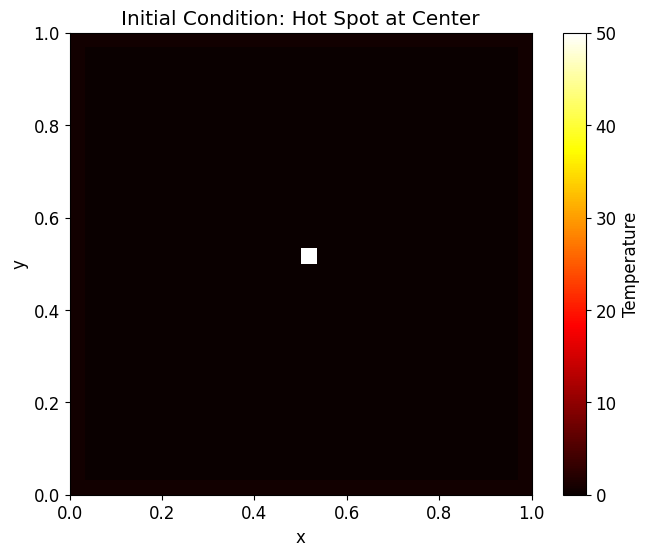

In [5]:
# Initial condition: hot spot in the middle
u0 = np.zeros((nx, ny))
u0[nx//2, ny//2] = center_value

apply_heat_boundary_condition(u0, dx, dy, a, b, c)

if verify_boundary_condition(u0, dx, dy, a, b, c):
    print("Boundary conditions verified successfully.")
else:
    print("Boundary conditions verification failed.")

# Visualize initial condition
plt.figure(figsize=(8, 6))
plt.imshow(u0, origin='lower', cmap='hot', extent=[0, lx, 0, ly])
plt.colorbar(label='Temperature')
plt.title('Initial Condition: Hot Spot at Center')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 🚀 Method 1: Explicit Euler Scheme

In [6]:
def check_cfl_condition(alpha, dt, dx, dy):
    """Check the CFL condition for stability."""
    cfl_x = alpha * dt / dx**2
    cfl_y = alpha * dt / dy**2
    if cfl_x + cfl_y > 0.5:
        print(f"Warning: CFL condition not met! (CFL_x + CFL_y = {cfl_x + cfl_y:.2f} > 0.5)")
    else:
        print(f"CFL condition met. (CFL_x + CFL_y = {cfl_x + cfl_y:.2f} ≤ 0.5)")

### Boundary Conditions for the explicit Euler scheme
Robin's boundary condition, i.e.
$a u + b \frac{\partial u}{\partial n} = c$
   * a = 0 : Neumann boundary condition 
   * b = 0 : Dirichlet boundary condition
   * c = 0 : Homogeneous boudary condition


In [7]:
# apply boundary conditions for explicit scheme
# a = 0 : Neumann boundary condition 
# b = 0 : Dirichlet boundary condition
# c = 0 : Homogeneous boundary condition
def heat_explicit_boundary_condition(u, dx, dy, a, b, c):
    apply_heat_boundary_condition(u, dx, dy, a, b, c)
    verify_boundary_condition(u, dx, dy, a, b, c)

### One explicit Euler Step

In [8]:
def heat_explicit_step(u, alpha, dx, dy, dt, a=0, b=0, c=0):
    """
    Perform one explicit Euler step for the 2D heat equation.
    """
    u = u.copy()
    lamx = alpha * dt / dx**2
    lamy = alpha * dt / dy**2
    un = u.copy()
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]
    + lamx * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1])
    + lamy * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, :-2]))
    
    if a!=0 or b!=0:
        heat_explicit_boundary_condition(u, dx, dy, a, b, c)
        assert verify_boundary_condition(u, dx, dy, a, b, c), "Boundary condition not satisfied!"
    return u

### nt explicit Euler Steps

In [9]:
def heat_explicit(u, alpha, dx, dy, dt, nt, a=0, b=0, c=0):
    """
    Solve heat equation using explicit Euler for nt time steps.
    """
    check_cfl_condition(alpha, dt, dx, dy)
    for _ in range(nt):
        u = heat_explicit_step(u, alpha, dx, dy, dt, a, b, c)
    return u

## 🏗️ Method 2: Crank-Nicolson Scheme

In [10]:
import numpy as np
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve

def Crank_Nicolson_matrices_boundary_condition(nx, ny, dx, dy, alpha, dt, a, b=0, c=0):
    """
    Erzeugt die Crank-Nicolson-Matrizen A, B für 2D-Wärmeleitung mit 
    Robin-Randbedingungen: a*u + b*du/dn = c auf allen Rändern.
    
    KORREKTE Implementierung: 
    - Innere Punkte: Standard Crank-Nicolson für Diffusionsgleichung
    - Randpunkte: Modifikation der Diffusionsgleichung unter Berücksichtigung der Randbedingung
    
    Parameter:
    - nx, ny: Anzahl Gitterpunkte in x- und y-Richtung
    - dx, dy: Gitterweiten
    - alpha: Diffusionskoeffizient
    - dt: Zeitschritt
    - a, b, c: Parameter der Robin-Randbedingung a*u + b*du/dn = c
    
    Rückgabe: A, B, rhs_fun
    """
    N = nx * ny
    r_x = alpha * dt / (2 * dx**2)
    r_y = alpha * dt / (2 * dy**2)
    
    def idx(i, j):
        return j * nx + i
    
    # Initialisiere Matrizen als dichte Arrays für einfache Manipulation
    A = np.eye(N)
    B = np.eye(N)
    rhs = np.zeros(N)
    
    # Baue Punkt für Punkt auf
    for j in range(ny):
        for i in range(nx):
            row = idx(i, j)
            
            # Bestimme ob Randpunkt
            at_left = (i == 0)
            at_right = (i == nx-1) 
            at_bottom = (j == 0)
            at_top = (j == ny-1)
            is_boundary = at_left or at_right or at_bottom or at_top
            
            if not is_boundary:
                # === INNERE PUNKTE: Standard Crank-Nicolson ===
                # du/dt = alpha * (d²u/dx² + d²u/dy²)
                # Diskretisierung: (u^{n+1} - u^n)/dt = alpha/2 * (L*u^{n+1} + L*u^n)
                # Umformen: (I + alpha*dt/2 * L) * u^{n+1} = (I - alpha*dt/2 * L) * u^n
                
                # A-Matrix (linke Seite)
                A[row, row] = 1 + 2*r_x + 2*r_y
                A[row, idx(i-1, j)] = -r_x
                A[row, idx(i+1, j)] = -r_x  
                A[row, idx(i, j-1)] = -r_y
                A[row, idx(i, j+1)] = -r_y
                
                # B-Matrix (rechte Seite)
                B[row, row] = 1 - 2*r_x - 2*r_y
                B[row, idx(i-1, j)] = r_x
                B[row, idx(i+1, j)] = r_x
                B[row, idx(i, j-1)] = r_y  
                B[row, idx(i, j+1)] = r_y
                
            else:
                # === RANDPUNKTE: Behandle verschiedene Fälle ===
                
                if abs(b) < 1e-12:
                    # DIRICHLET: a*u = c => u = c/a
                    A[row, :] = 0
                    A[row, row] = 1
                    B[row, :] = 0
                    rhs[row] = c/a if abs(a) > 1e-12 else c
                    
                elif abs(a) < 1e-12:  
                    # PURE NEUMANN: b*du/dn = c
                    # Verwende modifizierte Diffusionsgleichung mit Ghost-Point-Methode
                    
                    A[row, row] = 1 + 2*r_x + 2*r_y
                    B[row, row] = 1 - 2*r_x - 2*r_y
                    
                    # Behandle jede Randrichtung
                    if at_left and not (at_bottom or at_top):
                        # du/dx = -c/b an der linken Wand (Normale zeigt nach links)
                        # Ghost point: u[-1,j] = u[1,j] + 2*dx*c/b  
                        # Diskretisierung: (u[1,j] - u[-1,j])/(2*dx) = -c/b
                        A[row, idx(i+1, j)] = -2*r_x
                        B[row, idx(i+1, j)] = 2*r_x
                        rhs[row] = -2*r_x*dx*c/b*alpha*dt
                        
                    elif at_right and not (at_bottom or at_top):
                        # du/dx = c/b an der rechten Wand
                        A[row, idx(i-1, j)] = -2*r_x  
                        B[row, idx(i-1, j)] = 2*r_x
                        rhs[row] = 2*r_x*dx*c/b*alpha*dt
                        
                    elif at_bottom and not (at_left or at_right):
                        # du/dy = -c/b an der unteren Wand  
                        A[row, idx(i, j+1)] = -2*r_y
                        B[row, idx(i, j+1)] = 2*r_y
                        rhs[row] = -2*r_y*dy*c/b*alpha*dt
                        
                    elif at_top and not (at_left or at_right):
                        # du/dy = c/b an der oberen Wand
                        A[row, idx(i, j-1)] = -2*r_y
                        B[row, idx(i, j-1)] = 2*r_y  
                        rhs[row] = 2*r_y*dy*c/b*alpha*dt
                        
                    # Behandle Nachbarpunkte in den anderen Richtungen normal
                    if not at_left and i > 0:
                        A[row, idx(i-1, j)] = -r_x
                        B[row, idx(i-1, j)] = r_x
                    if not at_right and i < nx-1:
                        A[row, idx(i+1, j)] = -r_x  
                        B[row, idx(i+1, j)] = r_x
                    if not at_bottom and j > 0:
                        A[row, idx(i, j-1)] = -r_y
                        B[row, idx(i, j-1)] = r_y
                    if not at_top and j < ny-1:
                        A[row, idx(i, j+1)] = -r_y
                        B[row, idx(i, j+1)] = r_y
                        
                else:
                    # ROBIN: a*u + b*du/dn = c
                    # Verwende einseitige Differenzen für du/dn und löse nach u auf
                    
                    if at_left and not (at_bottom or at_top):
                        # a*u[i,j] - b*(u[i+1,j] - u[i,j])/dx = c
                        # (a + b/dx)*u[i,j] - (b/dx)*u[i+1,j] = c
                        A[row, row] = a + b/dx
                        A[row, idx(i+1, j)] = -b/dx
                        B[row, :] = 0  # Randbedingung ist zeitunabhängig
                        rhs[row] = c
                        
                    elif at_right and not (at_bottom or at_top):
                        # a*u[i,j] + b*(u[i,j] - u[i-1,j])/dx = c
                        A[row, row] = a + b/dx
                        A[row, idx(i-1, j)] = -b/dx
                        B[row, :] = 0
                        rhs[row] = c
                        
                    elif at_bottom and not (at_left or at_right):
                        # a*u[i,j] - b*(u[i,j+1] - u[i,j])/dy = c
                        A[row, row] = a + b/dy
                        A[row, idx(i, j+1)] = -b/dy
                        B[row, :] = 0
                        rhs[row] = c
                        
                    elif at_top and not (at_left or at_right):
                        # a*u[i,j] + b*(u[i,j] - u[i,j-1])/dy = c
                        A[row, row] = a + b/dy
                        A[row, idx(i, j-1)] = -b/dy
                        B[row, :] = 0
                        rhs[row] = c
                        
                    else:
                        # Eckpunkte: Verwende Dirichlet-Approximation
                        # Für Eckpunkte ist Robin-Randbedingung nicht eindeutig definiert
                        A[row, :] = 0
                        A[row, row] = 1  
                        B[row, :] = 0
                        rhs[row] = c/a if abs(a) > 1e-12 else 0
    
    # Konvertiere zu sparse Matrizen
    A = csr_matrix(A)
    B = csr_matrix(B)
    
    def rhs_fun():
        return rhs.copy()
    
    return A, B, rhs_fun


def test_heat_diffusion():
    """Test der korrigierten Implementierung mit verschiedenen Randbedingungen"""
    
    # Gitterparameter  
    nx, ny = 21, 21
    lx, ly = 1.0, 1.0
    dx, dy = lx/(nx-1), ly/(ny-1)
    
    # Physikalische Parameter
    alpha = 0.01
    dt = 0.001
    t_end = 0.02
    n_steps = int(t_end / dt)
    
    def idx(i, j):
        return j * nx + i
    
    # Anfangsbedingung: Gauss Peak
    def create_initial_condition():
        u = np.zeros(nx * ny)
        x0, y0 = lx/2, ly/2
        sigma = 0.1
        for j in range(ny):
            for i in range(nx):
                xi, yj = i*dx, j*dy
                u[idx(i, j)] = 50.0 * np.exp(-((xi-x0)**2 + (yj-y0)**2)/(2*sigma**2))
        return u
    
    print("=== Test der korrigierten Implementierung ===\n")
    
    # Test 1: Dirichlet u = 0
    print("1. Dirichlet BC: u = 0")
    A1, B1, rhs1_fun = Crank_Nicolson_matrices_boundary_condition(
        nx, ny, dx, dy, alpha, dt, a=1.0, b=0.0, c=0.0)
    
    u1 = create_initial_condition()
    print(f"   Anfang: max = {np.max(u1):.2f}")
    
    rhs1 = rhs1_fun()
    max_values = [np.max(u1)]
    
    for step in range(n_steps):
        rhs_total = B1 @ u1 + rhs1
        u1 = spsolve(A1, rhs_total)
        max_values.append(np.max(u1))
        
        if step % (n_steps//4) == 0 or step == n_steps-1:
            print(f"   t = {step*dt:.3f}: max = {np.max(u1):.4f}")
    
    is_monotonic = all(max_values[i] >= max_values[i+1] for i in range(len(max_values)-1))
    print(f"   Maximum monoton fallend: {is_monotonic}")
    print(f"   Ende: max = {np.max(u1):.6f}\n")
    
    # Test 2: Neumann du/dn = 0  
    print("2. Neumann BC: du/dn = 0 (isoliert)")
    A2, B2, rhs2_fun = Crank_Nicolson_matrices_boundary_condition(
        nx, ny, dx, dy, alpha, dt, a=0.0, b=1.0, c=0.0)
        
    u2 = create_initial_condition()
    initial_mass = np.sum(u2) * dx * dy
    print(f"   Anfang: max = {np.max(u2):.2f}, Masse = {initial_mass:.3f}")
    
    rhs2 = rhs2_fun()
    
    for step in range(n_steps):
        rhs_total = B2 @ u2 + rhs2
        u2 = spsolve(A2, rhs_total)
        
        if step % (n_steps//4) == 0 or step == n_steps-1:
            current_mass = np.sum(u2) * dx * dy
            print(f"   t = {step*dt:.3f}: max = {np.max(u2):.4f}, Masse = {current_mass:.3f}")
    
    final_mass = np.sum(u2) * dx * dy
    mass_error = abs(final_mass - initial_mass) / initial_mass * 100
    print(f"   Massenerhaltung: {mass_error:.3f}% Fehler\n")
    
    # Test 3: Robin BC
    print("3. Robin BC: u + 0.1*du/dn = 0")
    A3, B3, rhs3_fun = Crank_Nicolson_matrices_boundary_condition(
        nx, ny, dx, dy, alpha, dt, a=1.0, b=0.1, c=0.0)
        
    u3 = create_initial_condition() 
    print(f"   Anfang: max = {np.max(u3):.2f}")
    
    rhs3 = rhs3_fun()
    max_values3 = [np.max(u3)]
    
    for step in range(n_steps):
        rhs_total = B3 @ u3 + rhs3
        u3 = spsolve(A3, rhs_total)
        max_values3.append(np.max(u3))
        
        if step % (n_steps//4) == 0 or step == n_steps-1:
            print(f"   t = {step*dt:.3f}: max = {np.max(u3):.4f}")
    
    is_monotonic3 = all(max_values3[i] >= max_values3[i+1] for i in range(len(max_values3)-1))
    print(f"   Maximum monoton fallend: {is_monotonic3}")
    print(f"   Ende: max = {np.max(u3):.6f}")
    
    return u1, u2, u3

if __name__ == "__main__":
    u1, u2, u3 = test_heat_diffusion()
    
    print("\n" + "="*50)
    print("WICHTIG: Alle Maxima sollten monoton fallen oder konstant bleiben!")
    print("Wenn Werte über die Anfangsbedingung ansteigen, ist die Implementierung falsch.")
    print("="*50)

=== Test der korrigierten Implementierung ===

1. Dirichlet BC: u = 0
   Anfang: max = 50.00
   t = 0.000: max = 49.9062
   t = 0.005: max = 49.4419
   t = 0.010: max = 48.9858
   t = 0.015: max = 48.5375
   t = 0.019: max = 48.1844
   Maximum monoton fallend: True
   Ende: max = 48.184441

2. Neumann BC: du/dn = 0 (isoliert)
   Anfang: max = 50.00, Masse = 3.142
   t = 0.000: max = 49.9062, Masse = 3.142
   t = 0.005: max = 49.4419, Masse = 3.142
   t = 0.010: max = 48.9858, Masse = 3.142
   t = 0.015: max = 48.5375, Masse = 3.142
   t = 0.019: max = 48.1844, Masse = 3.142
   Massenerhaltung: 0.000% Fehler

3. Robin BC: u + 0.1*du/dn = 0
   Anfang: max = 50.00
   t = 0.000: max = 49.9062
   t = 0.005: max = 49.4419
   t = 0.010: max = 48.9858
   t = 0.015: max = 48.5375
   t = 0.019: max = 48.1844
   Maximum monoton fallend: True
   Ende: max = 48.184441

WICHTIG: Alle Maxima sollten monoton fallen oder konstant bleiben!
Wenn Werte über die Anfangsbedingung ansteigen, ist die Implemen

In [11]:
def heat_implicit_step_correct(u, A, B, rhs_fun):
    """
    Korrekte Implementierung eines impliziten Zeitschritts.
    """
    u_vec = u.flatten()
    rhs = B @ u_vec + rhs_fun()
    u_new_vec = spsolve(A, rhs)
    return u_new_vec.reshape(u.shape)

def heat_implicit_step(u, A=None, B=None, rhs_fun=None):
    """
    Perform one implicit Crank-Nicolson step.
    """
    if A is None or B is None:
        return None
    if rhs_fun is None:
        u = u.copy().reshape(-1)
        u = spsolve(A, B @ u)
        return u.reshape((nx, ny))
    return heat_implicit_step_correct(u, A, B, rhs_fun)
    

In [12]:
def heat_implicit(u, alpha, dx, dy, dt, nt, a=0, b=0, c=0):
    """
    Solve heat equation using Crank-Nicolson for nt time steps.
    """
    u = u.copy().reshape(-1)
    # [A,B] = Crank_Nicolson_matrices(alpha, dx, dy, dt)
    [A,B, rhs_fun] = Crank_Nicolson_matrices_boundary_condition(nx, ny, dx, dy, alpha, dt, a, b, c)

    for n in range(nt):
        u = heat_implicit_step(u, A, B, rhs_fun)

    return u.reshape((nx, ny))

## 📊 Example 1: Static Comparison

In [13]:
def example1(alpha, cmap="coolwarm"):
    """
    Compare explicit and implicit schemes with static results and hover info.
    """

    u00 = u0.copy()
    heat_explicit_boundary_condition(u00, dx, dy, a, b, c)
    # Run explicit and implicit schemes
    ue = heat_explicit(u00, alpha, dx, dy, dt, nt, a, b, c)
    ui = heat_implicit(u00, alpha, dx, dy, dt, nt, a, b, c)
    
    print("Explicit Euler max:", np.max(ue), end=', ')
    print("Crank Nicolson max:", np.max(ui))

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axs[0].imshow(ue, origin="lower", cmap=cmap)
    axs[0].set_title("Explicit Euler")
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    
    im1 = axs[1].imshow(ui, origin="lower", cmap=cmap)
    axs[1].set_title("Implicit Crank Nicolson")
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    
    # Info-Display erstellen
    info_text0 = axs[0].text(0.02, 0.98, '', transform=axs[0].transAxes, 
                            verticalalignment='top', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    info_text1 = axs[1].text(0.02, 0.98, '', transform=axs[1].transAxes, 
                            verticalalignment='top', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    cursor0 = mplcursors.cursor(im0, hover=True)
    cursor1 = mplcursors.cursor(im1, hover=True)

    cursor0.connect("add", lambda sel: sel.annotation.set_text(
        f"Explizit: {ue[sel.index[1], sel.index[0]]:.2f}"))
    cursor1.connect("add", lambda sel: sel.annotation.set_text(
        f"Implizit: {ui[sel.index[1], sel.index[0]]:.2f}"))
    plt.show()
    
    return ue, ui
    

## 🎬 Example 2: Animation Comparison

In [14]:
def example2(alpha):
    """
    Create animated comparison with coordinate display - VSCode compatible.
    """
    nx, ny = u0.shape
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    im0 = axs[0].imshow(u0, origin="lower", cmap="coolwarm", animated=True)
    axs[0].set_title("Explicit Euler")
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(u0, origin="lower", cmap="coolwarm")
    axs[1].set_title("Crank Nicolson")
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    
    u00 = u0.copy()
    heat_explicit_boundary_condition(u00, dx, dy, a, b, c)

    u_explicit = u00.copy()
    u_implicit = u00.copy()

    # Globale Variablen für aktuelle Daten
    current_frame = [0]
    mouse_info = {'x': 0, 'y': 0, 'method': '', 'value': 0}
    
    # Layout anpassen
    plt.subplots_adjust(hspace=0.4)

    def update(frame):
        nonlocal u_explicit, u_implicit
        current_frame[0] = frame
        
        u_explicit_old = u_explicit.copy()
        u_explicit = heat_explicit_step(u_explicit, alpha, dx, dy, dt, a, b, c)
        im0.set_array(u_explicit)
        axs[0].set_title(f"Explicit Euler - Frame {frame}")
        
        if frame % 10 == 0:  # Weniger Print-Output
            print(f"Frame {frame}", end=' ')
        
        if np.allclose(u_explicit_old, u_explicit):
            print(f"\nExplicit method converged at frame {frame}")
            return [im0, im1]
        
        [A, B, rhs_fun] = Crank_Nicolson_matrices_boundary_condition(nx, ny, dx, dy, alpha, dt, a, b, c)
        u_implicit = heat_implicit_step(u_implicit, A, B, rhs_fun)
        im1.set_array(u_implicit)
        axs[1].set_title(f"Crank Nicolson - Frame {frame}")
        
        print("Explicit Euler max:", np.max(u_explicit), end=', ')
        print("Crank Nicolson max:", np.max(u_implicit))
        return [im0, im1]

    ani = FuncAnimation(fig, update, frames=nt, interval=100, blit=False)
    
    return HTML(ani.to_jshtml())

## Static Comparison

🌡️ 2D Heat Equation Solver

📊 Running static comparison...
alpha=0.01
a=1, b=1, c=20 
CFL condition met. (CFL_x + CFL_y = 0.01 ≤ 0.5)
Explicit Euler max: 5.370968473243654, Crank Nicolson max: 20.0


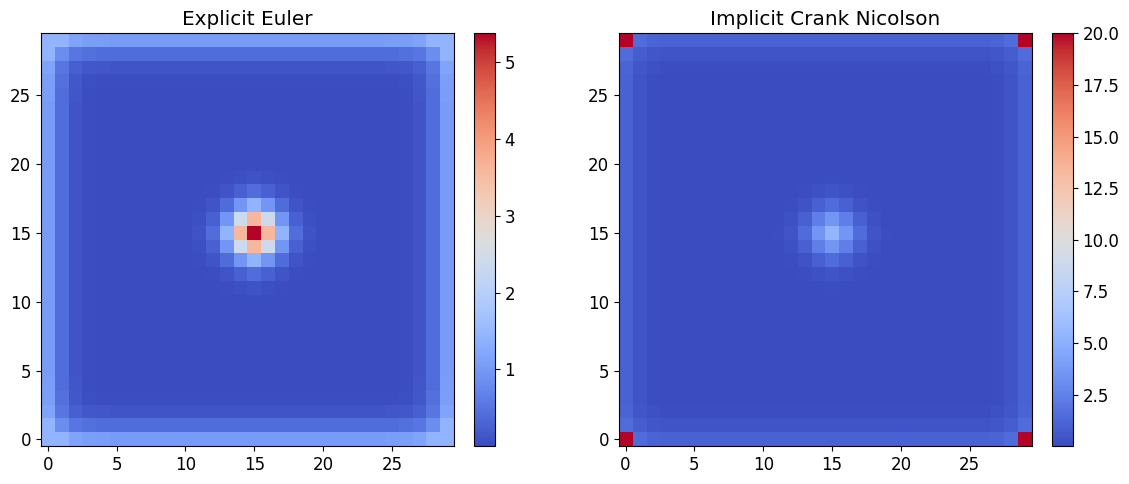

(array([[1.43704563e+00, 1.43704563e+00, 1.16325216e+00, 1.07313066e+00,
         1.05057630e+00, 1.04608190e+00, 1.04534324e+00, 1.04524040e+00,
         1.04522802e+00, 1.04522671e+00, 1.04522659e+00, 1.04522658e+00,
         1.04522658e+00, 1.04522658e+00, 1.04522658e+00, 1.04522658e+00,
         1.04522658e+00, 1.04522658e+00, 1.04522658e+00, 1.04522659e+00,
         1.04522671e+00, 1.04522802e+00, 1.04524040e+00, 1.04534324e+00,
         1.04608190e+00, 1.05057630e+00, 1.07313066e+00, 1.16325216e+00,
         1.43704563e+00, 1.43704563e+00],
        [1.43704563e+00, 8.18280489e-01, 5.35360570e-01, 4.42235016e-01,
         4.18928839e-01, 4.14284632e-01, 4.13521347e-01, 4.13415082e-01,
         4.13402289e-01, 4.13400936e-01, 4.13400808e-01, 4.13400797e-01,
         4.13400797e-01, 4.13400797e-01, 4.13400797e-01, 4.13400797e-01,
         4.13400797e-01, 4.13400797e-01, 4.13400797e-01, 4.13400808e-01,
         4.13400936e-01, 4.13402289e-01, 4.13415082e-01, 4.13521347e-01,
         

In [15]:
print("🌡️ 2D Heat Equation Solver")
print("=" * 50)
# Run static comparison
print("\n📊 Running static comparison...")
print(f"alpha={alpha}")
print(f"a={a}, b={b}, c={c} ")
# example1(alpha, 'hot')
example1(alpha, 'coolwarm')

## First Animation


📊 Running animation...
alpha=0.01
a=1, b=1, c=20 
Frame 0 Explicit Euler max: 49.099999999999994, Crank Nicolson max: 49.10999913305919
Frame 0 Explicit Euler max: 48.22024999999999, Crank Nicolson max: 48.23974816628091
Explicit Euler max: 47.360239699999994, Crank Nicolson max: 47.38875700863324
Explicit Euler max: 46.5194726601125, Crank Nicolson max: 46.556548663682676
Explicit Euler max: 45.69746590345797, Crank Nicolson max: 45.74265886075505
Explicit Euler max: 44.893749530891554, Crank Nicolson max: 44.946635696896074
Explicit Euler max: 44.107866347198, Crank Nicolson max: 44.16803928930623
Explicit Euler max: 43.33937149840345, Crank Nicolson max: 43.406441437934426
Explicit Euler max: 42.58783211986345, Crank Nicolson max: 42.66142529792479
Explicit Euler max: 41.852826994797326, Crank Nicolson max: 41.93258506161992
Explicit Euler max: 41.13394622294952, Crank Nicolson max: 41.21952564983391
Frame 10 Explicit Euler max: 40.43079089906827, Crank Nicolson max: 40.52186241211

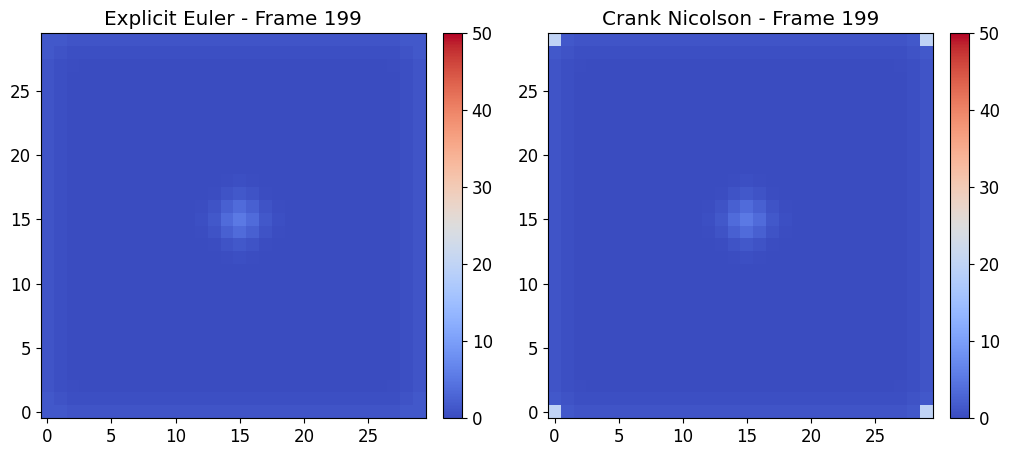

In [16]:
print("\n📊 Running animation...")
print(f"alpha={alpha}")
print(f"a={a}, b={b}, c={c} ")
example2(alpha)

## Unstable explicit scheme


🔬 Running parameter study...
dt : 0.028333, CFL = 0.5100
α = 0.5, CFL = 0.5100, Status: UNSTABLE
Frame 0 Explicit Euler max: 12.75, Crank Nicolson max: 20.0
Frame 0 Explicit Euler max: 13.025, Crank Nicolson max: 20.0
Explicit Euler max: 7.47691875, Crank Nicolson max: 20.0
Explicit Euler max: 7.642071124999999, Crank Nicolson max: 20.0
Explicit Euler max: 5.420876221875, Crank Nicolson max: 20.0
Explicit Euler max: 5.5445362597625, Crank Nicolson max: 20.0
Explicit Euler max: 4.339576668906201, Crank Nicolson max: 20.0
Explicit Euler max: 4.441807592356499, Crank Nicolson max: 20.0
Explicit Euler max: 3.680813729152274, Crank Nicolson max: 20.0
Explicit Euler max: 3.7702724566827435, Crank Nicolson max: 20.0
Explicit Euler max: 3.243546691303713, Crank Nicolson max: 20.0
Frame 10 Explicit Euler max: 3.3247749020496498, Crank Nicolson max: 20.0
Explicit Euler max: 2.937216993855797, Crank Nicolson max: 20.0
Explicit Euler max: 3.0129108895424825, Crank Nicolson max: 20.0
Explicit Eule

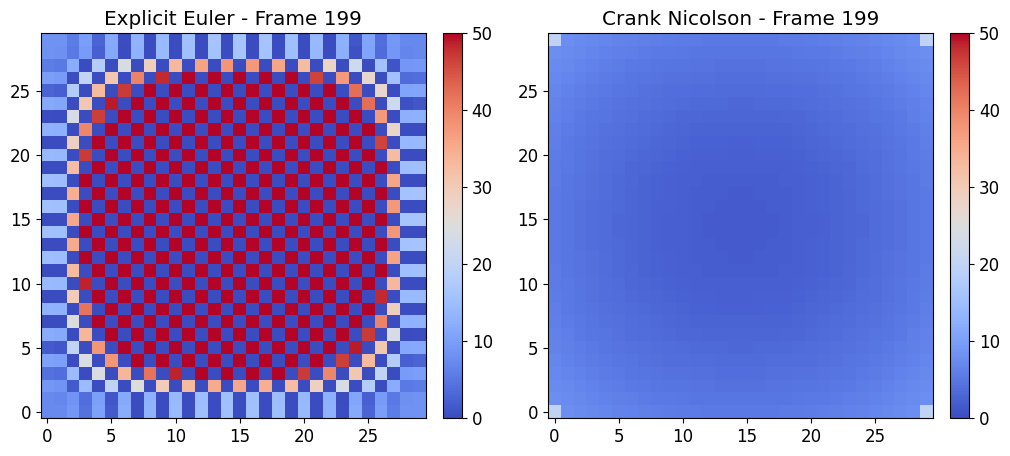

In [17]:
print("\n🔬 Running parameter study...")

# provoke instability
dt_backup = dt
dt = 0.51/(alpha*(1/dx**2 + 1/dy**2))
cfl = alpha * dt * (1/dx**2 + 1/dy**2)
print(f"dt : {dt:.6f}, CFL = {cfl:.4f}")
stability = "STABLE" if cfl<0.5 else "UNSTABLE"
print(f"α = 0.5, CFL = {cfl:.4f}, Status: {stability}")
example2(alpha)
print("\n✅ Analysis complete!")
dt = dt_backup

## 1. Pytorch Imports

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 2. Auxiliary functions for the PDE

In [19]:
## Laplacian operator using numpy
def laplacian_np(u, dx, dy):
    H, W = u.shape
    lap = np.zeros_like(u)
    lap[1:-1,1:-1] = (
        (u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1]) / dx**2
        + (u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,0:-2]) / dy**2
    )
    return lap

def step_explicit(u, alpha, dx, dy, dt):
    return u + dt * alpha * laplacian_np(u, dx, dy)

def random_initial_field(H, W, n_gaussians=2):
    x = np.linspace(0,1,H)
    y = np.linspace(0,1,W)
    X, Y = np.meshgrid(x, y, indexing='ij')
    field = np.zeros((H, W))
    for _ in range(n_gaussians):
        cx = np.random.rand()
        cy = np.random.rand()
        amp = 0.5 + np.random.rand() * 0.5
        sigma = 0.04 + 0.12 * np.random.rand()
        field += amp * np.exp(-((X-cx)**2 + (Y-cy)**2) / (2*sigma*sigma))
    return np.clip(field, 0.0, None)

## 3. Dataset and Model for RNN

In [27]:
class HeatSeqDataset(Dataset):
    def __init__(self, data, K=3):
        self.data = data
        self.K = K

    def __len__(self):
        return len(self.data) - self.K

    def __getitem__(self, idx):
        window = self.data[idx:idx+self.K]
        target = self.data[idx+self.K]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# --------------------------------------------------
# Encoder
# --------------------------------------------------
class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, stride=2, padding=1),  # -> (H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),           # -> (H/4, W/4)
            nn.ReLU()
        )
        self.fc = nn.Linear(16 *  (30//4) * (30//4), latent_dim)  # auf 30x30 ausgelegt

    def forward(self, x):
        z = self.conv(x)
        z = z.view(z.size(0), -1)
        return self.fc(z)



# --------------------------------------------------
# Decoder
# --------------------------------------------------

class Decoder(nn.Module):
    def __init__(self, latent_dim=64, out_channels=1, nx=30, ny=30):
        super().__init__()
        self.nx, self.ny = nx, ny
        self.fc = nn.Linear(latent_dim, 16 * 3 * 3)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, out_channels, 3, stride=2),
        )

    def forward(self, z):
        z = self.fc(z).view(z.size(0), 16, 3, 3)
        out = self.deconv(z)
        # Croppen auf gewünschte Gridgröße
        out = out[:, :, :self.nx, :self.ny]
        return out


# --------------------------------------------------
# HeatRNN
# --------------------------------------------------
class HeatRNN(nn.Module):
    def __init__(self, latent_dim=64, K=3, nx=30, ny=30):
        super().__init__()
        self.encoder = Encoder(in_channels=1, latent_dim=latent_dim)
        self.rnn = nn.LSTM(latent_dim, latent_dim, batch_first=True)
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=1, nx=nx, ny=ny)

    def forward(self, x):
        B, K, C, H, W = x.shape
        encs = []
        for k in range(K):
            encs.append(self.encoder(x[:, k]))
        encs = torch.stack(encs, dim=1)  # (B, K, latent_dim)
        out_seq, _ = self.rnn(encs)
        last = out_seq[:, -1]
        return self.decoder(last)


## 4. Boundary Condition

In [21]:
def apply_boundary(u, a=1.0, b=0.0, c=0.0, dx=1.0, dy=1.0):
    """
    Wendet allgemeine Randbedingungen a*u + b*du/dn = c an.
    Nutzt die vorhandene Funktion apply_heat_boundary_condition.
    """
    u_new = u.copy()
    apply_heat_boundary_condition(u_new, dx, dy, a, b, c)
    return u_new

## 5. RNN-Trainingsroutine + Vergleich mit klassischen Methoden

In [ ]:
def solve_with_rnn(
    u0: np.ndarray,
    *,
    alpha: float = 0.01,
    dt: float = 0.0005,
    nt: int = 200,
    a: float = 1.0,
    b: float = 0.0,
    c: float = 0.0,
    K: int = 3,
    latent_dim: int = 64,
    batch_size: int = 16,
    n_sequences: int = 20,
    device: str = "cpu"
):
    """
    Trainiert ein RNN auf Zeitfolgen der Wärmeleitungsgleichung.

    u0: Anfangsfeld (nx, ny)
    alpha: Diffusionskoeffizient
    dt, nt: Zeitschritt und Anzahl Zeitschritte
    a,b,c: Parameter für Randbedingungen
    K: Länge Input-Fenster
    latent_dim: Dimension der latenten Repräsentation
    batch_size: Minibatch-Größe
    n_sequences: Anzahl Trainingssequenzen
    device: 'cpu' oder 'cuda'
    """
    nx, ny = u0.shape
    dx, dy = 1.0/nx, 1.0/ny

    # Trainingsdaten generieren
    all_sequences = []
    for s in range(n_sequences):
        u = u0.copy()
        seq = [u.copy()]
        for n in range(1, nt):
            u = step_explicit(u, alpha, dx, dy, dt)
            u = apply_boundary(u, a=a, b=b, c=c, dx=dx, dy=dy)
            seq.append(u.copy())
        all_sequences.append(np.stack(seq, axis=0))

    all_sequences = np.stack(all_sequences, axis=0)
    all_sequences = all_sequences / all_sequences.max()

    # Split train/val
    n_train = int(0.8 * all_sequences.shape[0])
    train_data = all_sequences[:n_train]
    val_data   = all_sequences[n_train:]

    train_loader = DataLoader(HeatSeqDataset(train_data, K=K),
                              batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(HeatSeqDataset(val_data, K=K),
                              batch_size=batch_size, shuffle=False)

    # Modell mit dynamischer Dimension
    model = HeatRNN(latent_dim=latent_dim, K=K, nx=nx, ny=ny).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    # Training
    for epoch in range(1, 6):
        model.train(); t_loss=0; t_count=0
        for window,target in train_loader:
            window=window.to(device); target=target.to(device)
            pred=model(window)
            loss=mse(pred,target)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            t_loss+=loss.item()*window.shape[0]; t_count+=window.shape[0]
        print(f"Epoch {epoch}: train_loss={t_loss/t_count:.4e}")

    # Rollout-Test
    model.eval()
    with torch.no_grad():
        sample=torch.tensor(val_data[0:1],dtype=torch.float32).to(device)
        window_frames=sample[:,0:K].unsqueeze(2)
        M=min(5,sample.shape[1]-K)
        preds=[]; gt=sample[0,K:K+M].cpu().numpy()
        for m in range(M):
            pred=model(window_frames)
            preds.append(pred.cpu().numpy()[0,0])
            window_frames=torch.cat([window_frames[:,1:], pred.unsqueeze(1)], dim=1)

    # Vergleichsplots
    for i in range(M):
        fig,ax=plt.subplots(1,3,figsize=(9,3))
        ax[0].imshow(preds[i],origin="lower"); ax[0].set_title("RNN pred")
        ax[1].imshow(gt[i],origin="lower"); ax[1].set_title("Ground truth")
        ax[2].imshow(np.abs(preds[i]-gt[i]),origin="lower"); ax[2].set_title("Error")
        for a in ax: a.axis("off")
        plt.show()

    return model



## 6. Example Call for the RNN Method

In [30]:
# %%
model = solve_with_rnn(
    u0,
    alpha=0.01,
    dt=0.0005,
    nt=200,
    a=1.0, b=0.0, c=0.0,
    K=3,
    latent_dim=64,
    device="cpu"
)


print("\n✅ RNN training and evaluation complete!")

TypeError: HeatRNN.__init__() got an unexpected keyword argument 'input_size'

## 📝 Summary

This notebook demonstrates:

1. **Explicit Euler Method**: Simple to implement but limited by stability constraints (CFL condition)
2. **Crank-Nicolson Method**: More complex but unconditionally stable
3. **Parameter Analysis**: How different diffusion coefficients affect the solution
4. **Visualization**: Static plots and animated comparisons

### Key Takeaways:
- The CFL condition limits the time step for explicit methods
- Implicit methods can use larger time steps without stability issues
- Both methods converge to similar solutions when stable
- Animation helps visualize the time evolution of the heat diffusion process

### Next Steps:
- Experiment with different initial conditions
- Try different boundary conditions
- Compare with analytical solutions for simple cases
- Implement higher-order schemes